In [9]:
import numpy as np
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
from method import InvariantSearch
from policy import RandomPolicy, LinearDMLPolicy
from utils import create_subset
from dataprep import get_activity, pre_process
from validation import validate_simu
import matplotlib.pyplot as plt
import seaborn as sns
from environment_simulation import LinearEnv

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# set parameters
a_label = 'send'
e_label = 'user'
y_label = 'y'
min_size = 2
alpha = 0.05

# the lists of features
activity_feature = ['C(decision_bucket)', 'location', 'variation_indicator', 'engagement']
interaction = activity_feature
control_feature = ['square_root_yesterday', 'temperature', 'pre_treatment_steps']
main_effect =  activity_feature + control_feature

# create all candidate subsets
candidate_sets = create_subset(interaction, min_size=min_size)

## Data preparation

In [12]:
activity_df = get_activity()

# preprocess data
all_df = pre_process(activity_df, a_label, e_label)

## Validation

In [13]:
full_policy = LinearDMLPolicy(main_effect, interaction, name='Full', y_label=y_label)
zero_policy = RandomPolicy(0.0, 'zero')
random_policy = RandomPolicy(0.5, 'Random')

baseline_policies = [full_policy, random_policy]
environment = LinearEnv(main_effect, interaction, y_label=y_label)
search_algo = InvariantSearch(activity_feature, control_feature, y_label=y_label)

# compute the out-of-environment validation
reward_df = validate_simu(all_df, search_algo, environment, 
                          candidate_sets, main_effect, 
                          baseline_policies, zero_policy)

100%|██████████| 27/27 [00:12<00:00,  2.10it/s]


In [14]:
reward_df.to_csv("reward_df.csv", index=False)

In [15]:
avg_reward = reward_df.groupby(['model', 'test_user'])['exp_reward'].mean().reset_index()
avg_reward = avg_reward.pivot(index='test_user', columns='model', values='exp_reward')
avg_reward['diff'] = avg_reward['Inv'] - avg_reward['Full']
avg_reward = avg_reward.sort_values("diff")
avg_reward['Test user'] = range(1, 28)

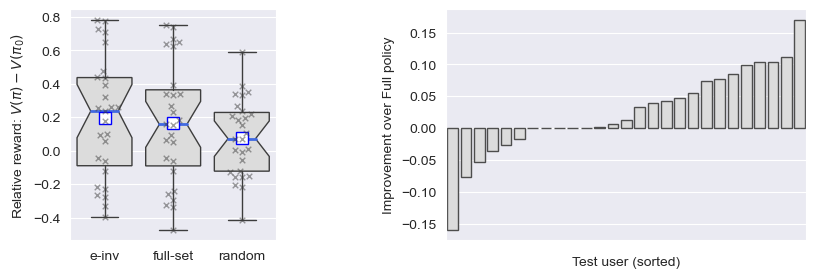

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9.5, 3), sharey=False, gridspec_kw={'width_ratios': [1, 1.75]})

g1 = sns.swarmplot(
    data=reward_df, x="model", y="exp_reward",
    marker="x", linewidth=1, ax=ax1, alpha=.5, size=4
)

g2 = sns.boxplot(data=reward_df, x="model", y="exp_reward",
        notch=True, showcaps=True, ax=ax1, linewidth=1,
        flierprops={"marker": "x"},
        boxprops={"facecolor": "gainsboro"},
        medianprops={"color": "royalblue", "linewidth": 2}, 
        showmeans=True,
        meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue", "markersize":8},
        showfliers=False)

g2.set_ylabel(r"Relative reward: $V(\pi) - V(\pi_0)$")
g2.set_xlabel("")
g2.set_xticklabels(['e-inv', 'full-set', 'random'])

g3 = sns.barplot(x='Test user', y='diff', data=avg_reward, edgecolor="0.3", facecolor='gainsboro', ax=ax2)
g3.set_ylabel("Improvement over Full policy")
g3.set_xlabel("Test user (sorted)")
g3.set(xticklabels=[])
g3.tick_params(bottom=False)

plt.subplots_adjust(wspace=0.6)
plt.savefig('zero_shot_simu.pdf', bbox_inches='tight')